<a href="https://colab.research.google.com/github/biditdas18/Generative_Adversarial_Network_Fake_Celebrity_Faces/blob/master/GAN_Generating_Fake_Faces(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This section of code also deals with the development of GAN and achieves same objective as that of the file GAN Generating Fake Faces but with better visualization, code simplification and plotting of generator and discriminator loss function

In [0]:
cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [0]:
# Make necessary imports
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense, Reshape, Flatten,\
Conv2D,Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import sys, os

In [0]:
# Load in the data
def load_real_samples():
  # load the face dataset
  data = np.load('img_align_celeba.npz')
  X = data['arr_0']
  # Convert from unsigned int to float
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5)/127.5
  return X

x_train = load_real_samples()
print("x_train.shape:", x_train.shape)

x_train.shape: (50000, 80, 80, 3)


In [0]:
# Flatten the data
N, H, W, C = x_train.shape
D = H * W * C
# x_train = x_train.reshape(-1, D)

In [0]:
# Dimensionality of the latent space
latent_dim = 100

In [0]:
# Get the generator model
def build_generator(latent_dim):
  model = Sequential()
  # foundation of 5 x 5 feature map
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5,5,128)))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(5,5),activation='tanh', padding='same'))
  return model

In [0]:
# Get the discriminator model
def build_discriminator(img_size=(80,80,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (5,5), padding='same', input_shape=img_size))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(img_size=(80,80,3))
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
# Train the GAN


# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images1'):
  os.makedirs('gan_images1')

In [0]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx])
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images1/%d.png" % epoch)
  plt.close()

In [0]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.69,       d_acc: 0.33, g_loss: 0.69
epoch: 101/30000, d_loss: 0.15,       d_acc: 0.97, g_loss: 2.81
epoch: 201/30000, d_loss: 0.38,       d_acc: 0.88, g_loss: 1.11
epoch: 301/30000, d_loss: 0.43,       d_acc: 0.88, g_loss: 2.36
epoch: 401/30000, d_loss: 0.40,       d_acc: 0.80, g_loss: 2.15
epoch: 501/30000, d_loss: 0.36,       d_acc: 0.88, g_loss: 2.16
epoch: 601/30000, d_loss: 0.47,       d_acc: 0.80, g_loss: 2.05
epoch: 701/30000, d_loss: 0.39,       d_acc: 0.84, g_loss: 1.75
epoch: 801/30000, d_loss: 0.42,       d_acc: 0.81, g_loss: 2.37
epoch: 901/30000, d_loss: 0.45,       d_acc: 0.75, g_loss: 2.00
epoch: 1001/30000, d_loss: 0.57,       d_acc: 0.72, g_loss: 1.66
epoch: 1101/30000, d_loss: 0.39,       d_acc: 0.86, g_loss: 2.19
epoch: 1201/30000, d_loss: 0.44,       d_acc: 0.86, g_loss: 1.81
epoch: 1301/30000, d_loss: 0.57,       d_acc: 0.72, g_loss: 1.72
epoch: 1401/30000, d_loss: 0.46,       d_acc: 0.78, g_loss: 2.03
epoch: 1501/30000, d_loss: 0.43,     

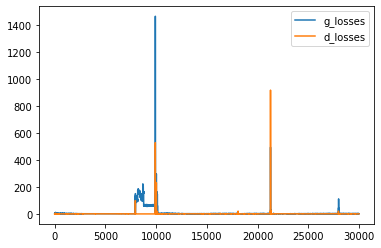

In [0]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()